### Simple neural network
<font size = 3> Simple neural network tasked with identifying AGN with jets from point sources with close to 100% accuracy. 

In [3]:
import tensorflow as tf
import numpy as np
import os
from astropy.io import fits
from astropy import stats
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

In [31]:
# These functions have since been updated and streamlined and are included in the building training set file. 

def get_clipped_images(filepath,xpix,ypix,sigma):
    '''
    Put FITS data from desired folder into a 3D array
    sigma = how many sigmas from the median background value to sigma clip the data to
    '''
    val_percentage = 0.5
    newpath = filepath.replace(os.sep, '/')
    dirs = os.listdir(newpath)
    n = len(dirs)
    data = np.empty(shape=(n,xpix,ypix),dtype=np.float64)
    for i in range(n):
        fullpath = '{}/{}'.format(newpath,dirs[i])
        d = fits.getdata(fullpath, ext=0)
        d[np.isnan(d)] = 0
        _,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
        d[d<median+sigma*std] = median+sigma*std
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        data[i,:,:] = d
    data = np.random.permutation(data)
    upper = int(n*val_percentage)
    return data[:upper],data[upper:]

def augment_data(data,size,xpix,ypix):
    '''
    Augment the data (3D array of images) by flipping and rotating the images.
    Size = upper bound on the final number of images 
    (actual_size can be much less depending on size/data_size multiples)
    '''
    rotations = size//len(data) # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations*len(data)
    training_set = np.empty((act_size, xpix, ypix))
    for i in range(len(data)):
        for j in range(len(angles)):
            if j % 2 == 0: training_set[i*len(angles)+j,:,:] = rotate(np.fliplr(data[i,:,:]), angles[j], reshape=False)
            else: training_set[i*len(angles)+j,:,:] = rotate(data[i,:,:], angles[j], reshape=False)
    return training_set

def train_test(data,percentage):
    '''
    Combines data sets in one 3D array, with a different label for each data set.
    Then randomly shuffles the data and splits into training and test sets.
    data = list 3D arrays containing desired data sets
    per = fraction of data to be in training set
    returns: train and test data (each a tupple containing the data and corresponding labels)
    '''
    d = np.concatenate(data,axis=0)
    n_images = len(d)
    labels = np.empty(n_images)
    i = 0
    for n in range(len(data)):
        labels[i:i+len(data[n])] = n
        i = len(data[n])
    rand_ind = np.random.permutation(range(n_images))
    d, labels = d[rand_ind], labels[rand_ind]
    n_train = np.int(np.round(n_images*percentage))
    train = (d[:n_train], labels[:n_train])
    test = (d[n_train:], labels[n_train:])
    return train, test

In [126]:
def resize(images,x_size,y_size):
    """
    Resize a set of images to a required size.
    Images are either cropped or padded with minimum value.
    Independent of the original image size.
    Resized around the centre of the image.
    """
    # This allows an input of 2D images or 3D arrays of images
    shape = np.shape(images)
    if len(shape) == 2:
        dummy = np.empty((1,shape[0],shape[1]))
        dummy[0,:,:] = images[:,:]
        images = dummy
        length = 1
    if len(shape) == 3:
        length = len(images)
    
    # Create an array to return new images
    resize = np.empty(shape=(length,y_size,x_size))
    
    # Decide whether to crop or pad based on relative image size
    for i in range(length):
        image = images[i,:,:]
        min_intensity = np.min(image)
        # FITS images are stored as [z,y,x]
        new_image = np.full((y_size,x_size),min_intensity)
        x_pix = image.shape[1]
        y_pix = image.shape[0]

        # Pixel numbers have to be integers so code is slightly
        # different depending on odd/even input
        x_diff = x_size - x_pix
        if x_diff % 2 != 0:
            x_odd = 0.5
        else:
            x_odd = 0
        y_diff = y_size - y_pix
        
        if y_diff % 2 != 0:
            y_odd = 0.5
        else: 
            y_odd = 0
        
        x = np.abs(x_diff/2)
        y = np.abs(y_diff/2)
        
        if x_diff > 0: # Requires zero padding
            x_min = int(x - x_odd)
            x_max = int(x + x_pix - x_odd)
            if y_diff == 0:
                new_image[:,x_min:x_max] = image[:,:]
            if y_diff > 0: # Requires zero padding
                y_min = int(y - y_odd)
                y_max = int(y + y_pix - y_odd)
                new_image[y_min:y_max,x_min:x_max] = image[:,:]
            if y_diff < 0: # Requires cropping
                y_min = int(y - y_odd)
                y_max = int(y_pix - y - y_odd)
                new_image[:,x_min:x_max] = image[y_min:y_max,:]    
                
        else: # Requires cropping
            x_min = int(x - x_odd)
            x_max = int(x_pix - x - x_odd)
            if y_diff == 0:
                new_image[:,:] = image[:,x_min:x_max]
            if y_diff > 0: # Requires zero padding
                y_min = int(y - y_odd)
                y_max = int(y + y_pix - y_odd)
                new_image[y_min:y_max,:] = image[:,x_min:x_max]
            if y_diff < 0: # Requires cropping
                y_min = int(y - y_odd)
                y_max = int(y_pix - y - y_odd)
                new_image[:,:] = image[y_min:y_max,x_min:x_max]
                
        resize[i,:,:] = new_image[:,:]
    return resize

In [127]:
# Directories with the FITS data
agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
ps_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Semester 2\compact sources'

In [128]:
# Get FITs images and augment data sets
xpix, ypix = 83, 83

fr1_learning, fr1_validation = get_clipped_images(agn_path,xpix,ypix,3)
fr2_learning, fr2_validation = get_clipped_images(ps_path,xpix,ypix,3)

label_one = np.full(len(fr1_validation),0)
label_two = np.full(len(fr2_validation),1)
validation_labels = np.concatenate((label_one,label_two))
validation = np.concatenate((fr1_validation,fr2_validation))
rand_ind = np.random.permutation(range(len(validation)))
validation = validation[rand_ind]
validation_labels = validation_labels[rand_ind]

In [132]:
print(len (fr1_learning), len(fr1_validation), len(fr1_learning)+len(fr1_validation))
print(len (fr2_learning), len(fr2_validation), len(fr2_learning)+len(fr2_validation))

1855 1855 3710
1536 1536 3072


In [27]:
pratice_images = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Semester 2\TGSS sources NEAREST interpolation.npy'

In [136]:
# Number of x pixels and y pixels in each image (must be the same for all images)
xpix, ypix = 83, 83
agn_augment = augment_data(fr1_learning,10000,xpix,ypix)
ps_augment = augment_data(fr2_learning,10000,xpix,ypix)

data = (agn_augment, ps_augment) # list of all data sets to be used
print (len(agn_augment))
print (len(ps_augment))

9275
9216


In [12]:
train, test = train_test(data,0.8) # training and test data, each in a tuple with data label array

In [13]:
np.save('trainingset.npy',train[0])
np.save('traininglabels.npy',train[1])
np.save('testset.npy',test[0])
np.save('testlabels.npy',test[1])

In [133]:
# Neural network
import numpy as np

train = np.load('trainingset.npy')
trainl = np.load('traininglabels.npy')
test = np.load('testset.npy')
testl = np.load('testlabels.npy')

init = tf.keras.initializers.glorot_normal(seed=None)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(xpix, ypix)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu,kernel_initializer=init),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation=tf.nn.relu,kernel_initializer=init),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation=tf.nn.relu,kernel_initializer=init),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.summary() 

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001)

# Compile the network
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6889)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3527680   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [134]:
print (len(train))
print (len(test))

14793
3698


In [146]:
# Perform fit
history = model.fit(train,trainl, epochs=30,validation_data=(validation,validation_labels))

Train on 14793 samples, validate on 3391 samples
Epoch 1/30
14793/14793 [==============================] - 31s 2ms/sample - loss: 1.7307 - accuracy: 0.7158 - val_loss: 0.7372 - val_accuracy: 0.9637
Epoch 2/30
14793/14793 [==============================] - 27s 2ms/sample - loss: 0.3627 - accuracy: 0.9544 - val_loss: 0.1242 - val_accuracy: 0.9723
Epoch 3/30
14793/14793 [==============================] - 26s 2ms/sample - loss: 0.1242 - accuracy: 0.9740 - val_loss: 0.0742 - val_accuracy: 0.9773
Epoch 4/30
14793/14793 [==============================] - 26s 2ms/sample - loss: 0.0884 - accuracy: 0.9771 - val_loss: 0.0679 - val_accuracy: 0.9776
Epoch 5/30
14793/14793 [==============================] - 27s 2ms/sample - loss: 0.0780 - accuracy: 0.9810 - val_loss: 0.0608 - val_accuracy: 0.9808
Epoch 6/30
14793/14793 [==============================] - 29s 2ms/sample - loss: 0.0719 - accuracy: 0.9816 - val_loss: 0.0619 - val_accuracy: 0.9791
Epoch 7/30
14793/14793 [==============================] -

In [147]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [34]:
acc_a = history.history['accuracy']
loss_a = history.history['loss']
val_acc_a = history.history['val_accuracy']
val_loss_a = history.history['val_loss']

In [45]:
acc_p = history.history['accuracy']
loss_p = history.history['loss']
val_acc_p = history.history['val_accuracy']
val_loss_p = history.history['val_loss']

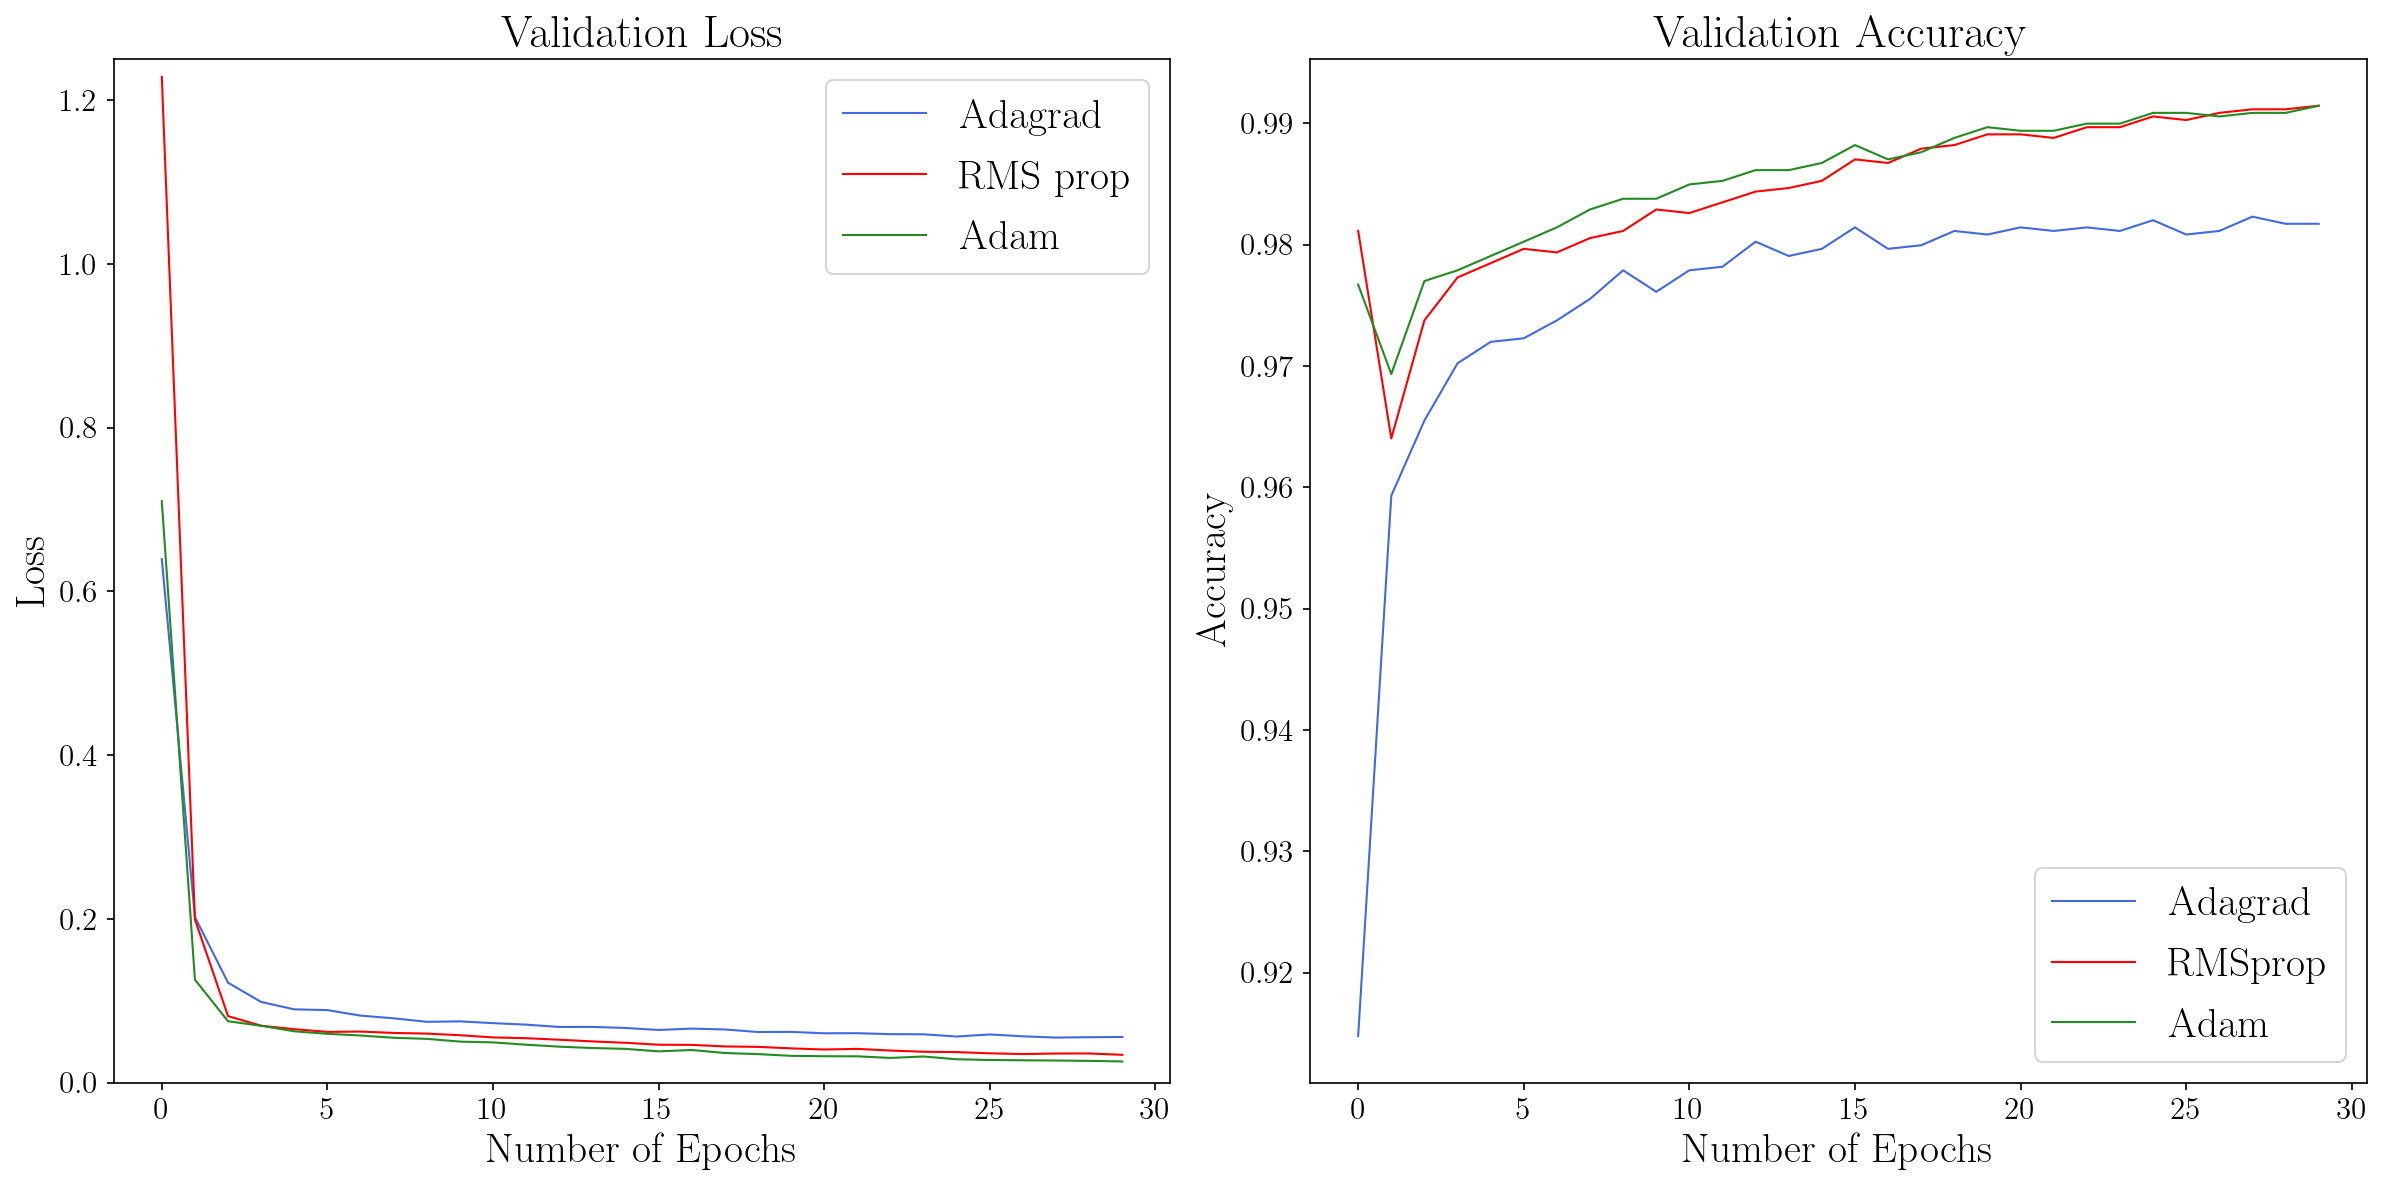

In [115]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

epochs_range = range(30)
plt.figure(figsize=(16,8),dpi=150)
plt.subplot(1,2,1)
plt.ylabel('Loss', fontsize=20)
plt.yticks(fontsize=15)
plt.ylim(0,1.25)
plt.xlabel('Number of Epochs', fontsize=20)
plt.xticks(fontsize=15)
plt.plot(epochs_range,val_loss_a,label='Adagrad',color='royalblue',linewidth=1.0)
plt.plot(epochs_range,val_loss_p,label='RMS prop',color='red',linewidth=1.0)
plt.plot(epochs_range,val_loss,label='Adam',color='forestgreen',linewidth=1.0)
plt.legend(fontsize=20)
plt.title('Validation Loss',fontsize=22)

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('Number of Epochs', fontsize=20)
plt.xticks(fontsize=15)
plt.plot(epochs_range,val_acc_a,label='Adagrad',color='royalblue',linewidth=1.0)
plt.plot(epochs_range,val_acc_p,label='RMSprop',color='red',linewidth=1.0)
plt.plot(epochs_range,val_acc,label='Adam',color='forestgreen',linewidth=1.0)
plt.legend(loc='lower right',fontsize=20)
plt.title('Validation Accuracy',fontsize=22)
plt.tight_layout()
plt.savefig('PointSourceOptimizer')
plt.show()

Above shows can achieve 100% accruacy between point sources and AGN even with a simple neural net.

In [148]:
validation_predicted = model.predict_classes(validation)

true_positive = []
true_negative = []
false_positive = []
false_negative = []

for i in range(len(validation_labels)):
    if validation_labels[i] == 0:
        if validation_predicted[i] == 0:
            true_positive.append(i)
        elif validation_predicted[i] == 1:
            false_negative.append(i)    
    if validation_labels[i] == 1:
        if validation_predicted[i] == 0:
            false_positive.append(i)
        elif validation_predicted[i] == 1:
            true_negative.append(i)  

agnrecall = len(true_positive)/(len(true_positive) + len(false_positive))
agnprecision = len(true_positive)/(len(true_positive) + len(false_negative))
agnf1 = 2*agnrecall*agnprecision/(agnrecall+agnprecision)

true_positive = []
true_negative = []
false_positive = []
false_negative = []

for i in range(len(validation_labels)):
    if validation_labels[i] == 0:
        if validation_predicted[i] == 0:
            true_negative.append(i)
        elif validation_predicted[i] == 1:
            false_positive.append(i)    
    if validation_labels[i] == 1:
        if validation_predicted[i] == 0:
            false_negative.append(i)
        elif validation_predicted[i] == 1:
            true_positive.append(i)  

psrecall = len(true_positive)/(len(true_positive) + len(false_positive))
psprecision = len(true_positive)/(len(true_positive) + len(false_negative))
psf1 = 2*psrecall*psprecision/(psrecall+psprecision)

np.save('validation_accuracy5',val_acc)
np.save('validation_loss5',val_loss)

In [149]:
print (val_acc[-1])
print (agnrecall)
print (agnprecision)
print (agnf1)
print (psrecall)
print (psprecision)
print (psf1)

0.99085814
0.995114006514658
0.9881401617250674
0.9916148228293211
0.9857972885732731
0.994140625
0.9899513776337114


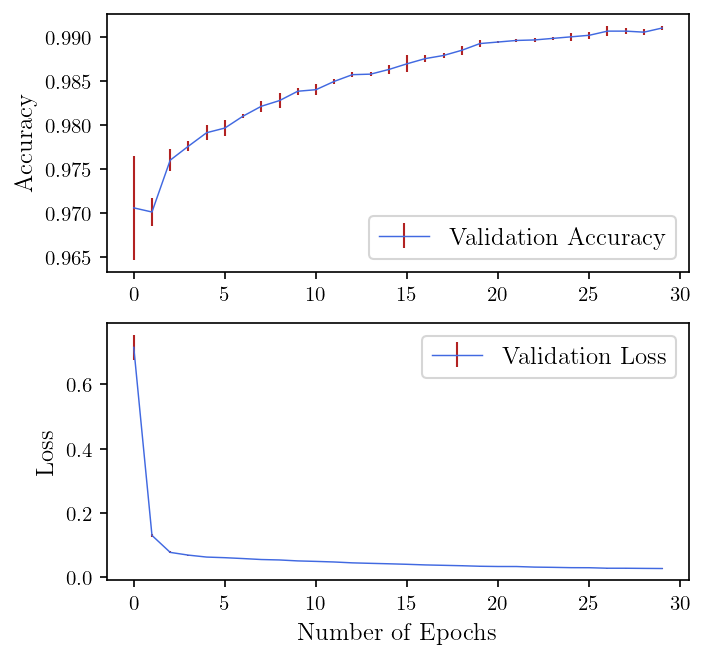

In [123]:
acc1 = np.load('validation_accuracy1.npy')
acc2 = np.load('validation_accuracy2.npy')
acc3 = np.load('validation_accuracy3.npy')
acc4 = np.load('validation_accuracy4.npy')
acc5 = np.load('validation_accuracy5.npy')

loss1 = np.load('validation_loss1.npy')
loss2 = np.load('validation_loss2.npy')
loss3 = np.load('validation_loss3.npy')
loss4 = np.load('validation_loss4.npy')
loss5 = np.load('validation_loss5.npy')

mean_accuracy = (acc1+acc2+acc3+acc4+acc5)/5
mean_loss = (loss1+loss2+loss3+loss4+loss5)/5

stddev_accuracy = np.sqrt(((acc1-mean_accuracy)**2 + (acc2-mean_accuracy)**2 + 
                          (acc3-mean_accuracy)**2 + (acc4-mean_accuracy)**2 + (acc5-mean_accuracy)**2)/5)

stddev_loss = np.sqrt(((loss1 - mean_loss)**2 + (loss2- mean_loss)**2 + 
                          (loss3 - mean_loss)**2 + (loss4 - mean_loss)**2 + (loss5 - mean_loss)**2)/5)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

epochs = range(30)
plt.figure(figsize=(5,5),dpi=150)

plt.subplot(2,1,1)
plt.ylabel('Accuracy',fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.errorbar(epochs, mean_accuracy, stddev_accuracy,label='Validation Accuracy',
             linewidth=0.7, elinewidth=1,color='royalblue', ecolor='firebrick')
plt.legend(loc='lower right',fontsize=12)

plt.subplot(2,1,2)
plt.xlabel('Number of Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.errorbar(epochs, mean_loss, stddev_loss,label='Validation Loss',
             linewidth=0.7, elinewidth=1,color='royalblue', ecolor='firebrick')
plt.legend(loc='upper right',fontsize=12)
plt.savefig('test')
plt.show()

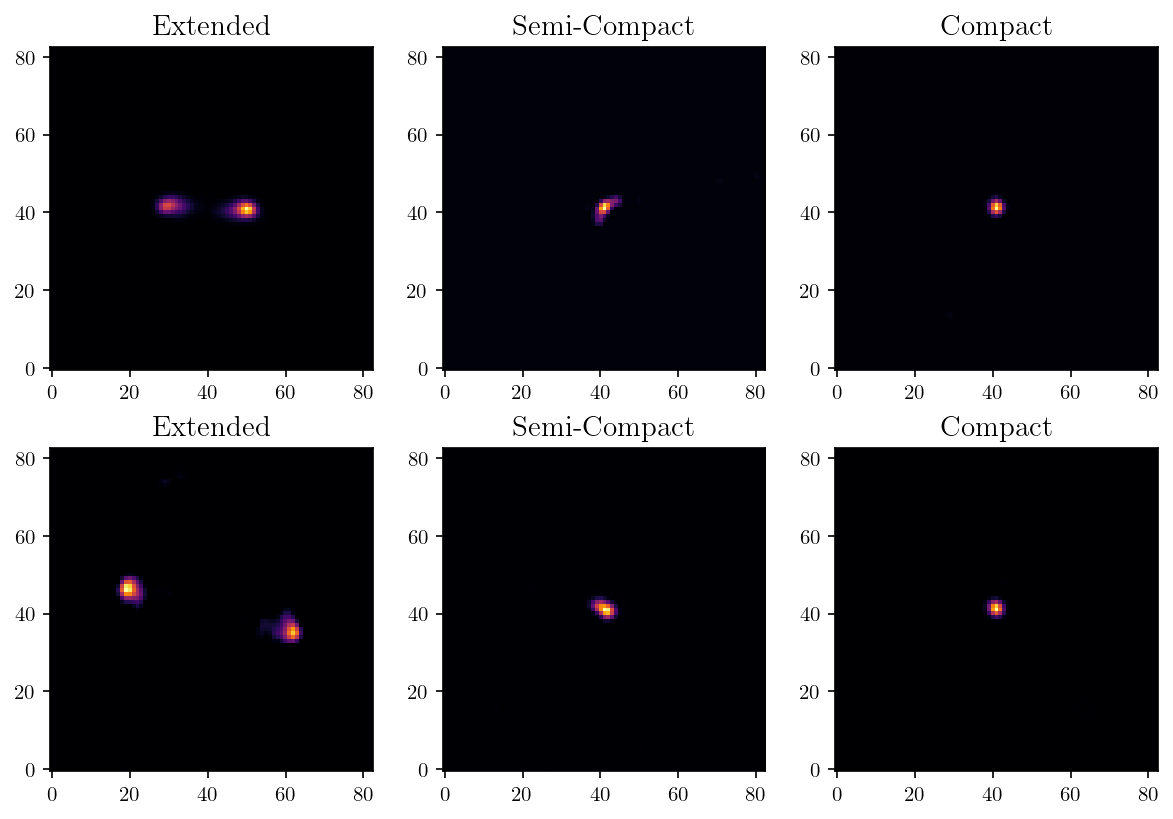

In [211]:
plt.figure(figsize=(8,5.5),dpi=150)
plt.subplot(2,3,1)
plt.title('Extended',fontsize=14)
plt.imshow(train[96],cmap='inferno',origin='lower')

plt.subplot(2,3,2)
plt.title('Semi-Compact',fontsize=14)
plt.imshow(train[3],cmap='inferno',origin='lower')

plt.subplot(2,3,3)
plt.title('Compact',fontsize=14)
plt.imshow(train[7],cmap='inferno',origin='lower')

plt.subplot(2,3,4)
plt.title('Extended',fontsize=14)
plt.imshow(train[23],cmap='inferno',origin='lower')

plt.subplot(2,3,5)
plt.title('Semi-Compact',fontsize=14)
plt.imshow(train[20],cmap='inferno',origin='lower')

plt.subplot(2,3,6)
plt.title('Compact',fontsize=14)
plt.imshow(train[0],cmap='inferno',origin='lower')

plt.savefig('examplesources')
plt.tight_layout()
plt.show()

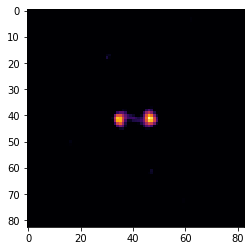

In [29]:
import os
sigma = 3
agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
dirs = os.listdir(agn_path)
dird = dirs[16]
d = fits.getdata(agn_path + '//' + dird, ext=0)
d[np.isnan(d)] = 0
_,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
d[d<median+sigma*std] = median+sigma*std
d = (d-np.min(d))/(np.max(d)-np.min(d))
plt.imshow(d,cmap='inferno')

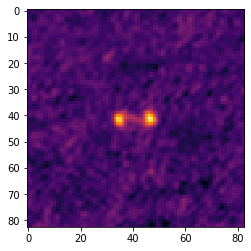

In [28]:
agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
dirs = os.listdir(agn_path)
dird = dirs[16]
d = fits.getdata(agn_path + '//' + dird, ext=0)
plt.imshow(d,cmap='inferno')

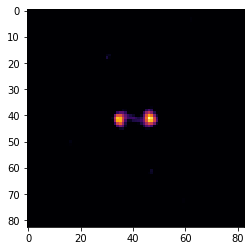

In [30]:
import os
sigma = 3
agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
dirs = os.listdir(agn_path)
dird = dirs[16]
d = fits.getdata(agn_path + '//' + dird, ext=0)
d[np.isnan(d)] = 0
_,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
d[d<median+sigma*std] = median+sigma*std
d = (d-np.min(d))/(np.max(d)-np.min(d))
plt.imshow(d,cmap='inferno')

In [53]:
def augment_data(data,size,xpix,ypix):
    '''
    Augment the data (3D array of images) by flipping and rotating the images.
    Size = upper bound on the final number of images 
    (actual_size can be much less depending on size/data_size multiples)
    '''
    rotations = size # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations
    training_set = np.empty((act_size, xpix, ypix))
    for j in range(len(angles)):
        if j % 2 == 0: training_set[j,:,:] = rotate(np.fliplr(data[:,:]), angles[j], reshape=False)
        else: training_set[j,:,:] = rotate(data[:,:], angles[j], reshape=False)
    return training_set

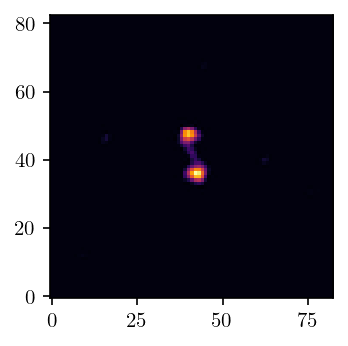

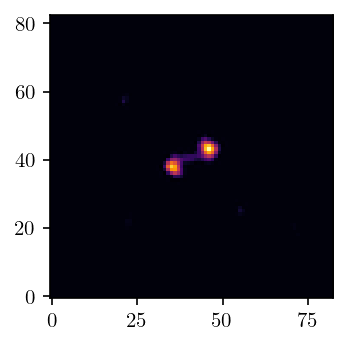

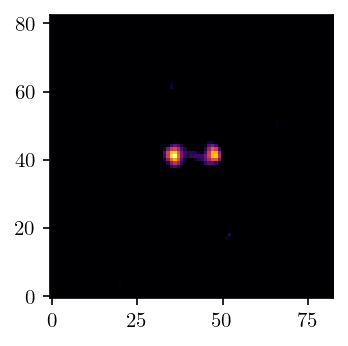

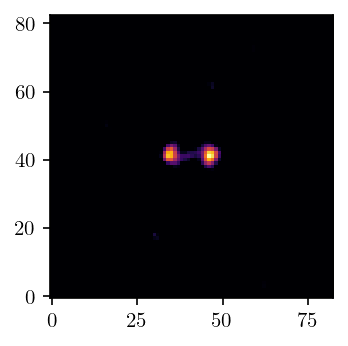

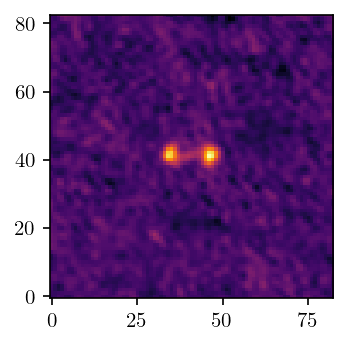

In [86]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(2.5,2.5),dpi=150)

images = augment_data(d,15,83,83)

plt.imshow(images[3],cmap='inferno',origin='lower')
plt.savefig('flip1')
plt.show()

plt.figure(figsize=(2.5,2.5),dpi=150)
plt.imshow(images[6],cmap='inferno',origin='lower')
plt.savefig('flip2')
plt.show()

plt.figure(figsize=(2.5,2.5),dpi=150)
plt.imshow(images[14],cmap='inferno',origin='lower')
plt.savefig('flip3')
plt.show()

sigma = 3
agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
dirs = os.listdir(agn_path)
dird = dirs[16]
d = fits.getdata(agn_path + '//' + dird, ext=0)
d[np.isnan(d)] = 0
_,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
d[d<median+sigma*std] = median+sigma*std
d = (d-np.min(d))/(np.max(d)-np.min(d))

plt.figure(figsize=(2.5,2.5),dpi=150)
plt.imshow(d,cmap='inferno',origin='lower')
plt.savefig('sigmaclip')
plt.show()

agn_path = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Data Preparation\RadioZooImages'
dirs = os.listdir(agn_path)
dird = dirs[16]
d = fits.getdata(agn_path + '//' + dird, ext=0)

plt.figure(figsize=(2.5,2.5),dpi=150)
plt.imshow(d,cmap='inferno',origin='lower')
plt.savefig('original')
plt.show()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)